# Xception : Images - Iteration #6 : Data Augementation & Fine Tuning

img_rows = 299 <br>
img_cols = 299 <br>
batch_size = 64 <br>
epochs = 40 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
Data augmentation  <br>
Fine-tining<br>
Fitting with supposed optimal LR : 0.0004  <br>

**<u>Results</u>**

Accuracy : 0.?? <br>
F1 score weighted : 0.??

#                                           Solving Overfitting

**Import packages**

In [50]:
from rackuten_project_lib import *

***Read DataFrame from saved pickele file - image Train set***

In [51]:
#Define Final DF directory 
path = 'D:/DataScienTest_WorkSpace/WS/Travail_Final/Datasets/'

#Directory containing Image Train set
images_dir_train = 'D:/DataScienTest_WorkSpace/WS//data/images/all/image_train/'

#Define output directory  Callback outputs , hdf5 files 
path_output_models = 'D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception/'

#Final DF name 
df_final_name =  'df_train_final.pkl'

In [52]:
#Read DF file
df_train_im = pd.read_pickle(path + df_final_name)

In [53]:
df_train_im.head()

,text,prdtypecode_org,prdtypecode,labels,image_name
0,olivia personalisiertes notizbuch seiten punkt...,10,0,adult books,image_1263597046_product_3804725264.jpg
1,journal arts art marche salon art asiatique pa...,2280,18,magazines,image_1008141237_product_436067568.jpg
2,grand stylet ergonomique bleu gamepad nintendo...,50,2,video games accessories,image_938777978_product_201115110.jpg
3,peluche donald europe disneyland marionnette d...,1280,7,toys for children,image_457047496_product_50418756.jpg
4,guerre tuques luc grandeur veut organiser jeu ...,2705,25,books,image_1077757786_product_278535884.jpg


In [54]:
display(df_train_im.shape)

(84916, 5)

In [55]:
display(df_train_im.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             84916 non-null  object
 1   prdtypecode_org  84916 non-null  int64 
 2   prdtypecode      84916 non-null  int64 
 3   labels           84916 non-null  object
 4   image_name       84916 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.9+ MB


None

In [58]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{0: 3116,
 1: 2508,
 2: 1681,
 3: 832,
 4: 2671,
 5: 3953,
 6: 764,
 7: 4870,
 8: 2070,
 9: 5045,
 10: 807,
 11: 2491,
 12: 3241,
 13: 5073,
 14: 4303,
 15: 803,
 16: 4993,
 17: 824,
 18: 4760,
 19: 4774,
 20: 1421,
 21: 4989,
 22: 2589,
 23: 10209,
 24: 2496,
 25: 2761,
 26: 872}

***Change prdtypecode column to string type***

In [59]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

 ***Split Train Set***

In [60]:
X_train_im, X_test_im = train_test_split(df_train_im, train_size = 0.8, random_state = 1234)

In [61]:
display(X_train_im.shape)
display(X_test_im.shape)

(67932, 5)

(16984, 5)

***Data Generator***

In [62]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 40

In [63]:
%%time
#Data Generator - Train
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  shear_range = 0.2,
                                  rotation_range = 45,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True
                                  #validation_split = 0.2
                                )

Wall time: 0 ns


In [64]:
%%time
#Data Generator - Validation
valid_datagen = ImageDataGenerator(rescale = 1./255)

Wall time: 0 ns


In [65]:
%%time

# Data Iterator - Train 
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train_im,
                                              directory = images_dir_train,
                                              #as_ext = True,
                                              x_col = 'image_name',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True  # défault
                                              #subset = 'training'
                                             )

Found 67932 validated image filenames belonging to 27 classes.
Wall time: 4.67 s


In [66]:
%%time

# # Data Iterator - Valid 
valid_generator = valid_datagen.flow_from_dataframe(dataframe = X_test_im, 
                                              directory = images_dir_train,
                                              #as_ext = True,
                                              x_col = 'image_name',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False
                                              #subset  = 'validation'
                                             )

Found 16984 validated image filenames belonging to 27 classes.
Wall time: 1.19 s


 ***Xception Implementation***

In [67]:
%%time
# Create Xception base model
xception = Xception(weights='imagenet', include_top = False, input_shape=(img_rows, img_cols,3))

# Freeze backbone layers 
for layer in xception.layers:
    layer.trainable = False   

Wall time: 923 ms


 ***Fine tuning***

In [68]:
# Unfreeze the last 60 layers of backbone 
for layer in xception.layers[-60:]:
    layer.trainable = True

***Solving Overfitting - Add L2 Regulization & Increase Dropout***

Qu’est-ce que la Regularization ? </br>
Diminution des poids  </br> </br>
La Regularization Weight Decay, en français Diminution des Poids permet d’améliorer la généralisation   </br>
lors de l’apprentissage du modèle.  </br>

De la sorte, le modèle va être performant à la fois sur les données d’entraînements mais aussi sur toutes les autres données. </br>

Comme expliqué dans cet article(https://inside-machinelearning.com/le-deep-learning-cest-quoi/),</br>
lors de l’apprentissage, certaines poids du modèle augmentent tandis que d’autres diminuent. </br></br>

Le but du Weight Decay est de diminuer la valeur des poids trop important.</br></br>

L1 & L2 Regularization</br>
En pratique, la Regularization s’effectue après avoir calculé la loss function. On applique la fonction de régularisation qui :</br></br>

- pour la L1-Regularization la somme des poids en valeur absolue multiplié par une constante α </br>
- pour la L2-Regularization la somme des poids au carré multiplié par une constante α </br>

D'autres outils existent pour contrer l’overfitting</br></br>

- Early stopping</br>
- Data Augmenation</br>
- Dropout</br>
- Batch Normalization</br>


In [69]:
model = Sequential()
model.add(xception)
# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation ='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)))

model.add(Dropout(rate = 0.3)) # Before was rate = 0.2
model.add(Dense(units = 512, activation ='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001)))

model.add(Dropout(rate = 0.3)) # Before was rate = 0.2
model.add(Dense(units = 27, activation ='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [70]:
print("Base_Model length: ", len(xception.layers))
print("Added model length: ", len( model.layers))

print('Last the last ten layers base model - Xception: \n ')  
for layer in xception.layers[-10:]:
    print(layer.name, "  " , layer.trainable)
    
#print('\n Layers of built model: \n')  
#for layer in model.layers:
#    print("", layer.name, "  " , layer.trainable)

Base_Model length:  132
Added model length:  7
Last the last ten layers base model - Xception: 
 
conv2d_15    True
block13_pool    True
batch_normalization_15    True
add_47    True
block14_sepconv1    True
block14_sepconv1_bn    True
block14_sepconv1_act    True
block14_sepconv2    True
block14_sepconv2_bn    True
block14_sepconv2_act    True


***Callbacks***

In [71]:
# For saving Callbacks and history results
date_result = '23012022'
nbr_Epochs = epochs
learning_rate = 0.0004 

In [77]:
%%time

chek_file_name = 'checkpoint_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +str(nbr_Epochs)+  'Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path_output_models + chek_file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', 
                             save_freq='epoch')

#Arrêter l'entraînement si le modèle n'évolue plus 

early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 4, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

#lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
#                              patience = 10,
#                               verbose = 1,
#                               mode='min'
#                              )

Wall time: 0 ns


 ***Compilation***

In [79]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate = learning_rate) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

Wall time: 0 ns


 ***Fit - train_generator***

In [80]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [81]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early]                    
                    )

Epoch 1/40
1061/1061 [==============================] - ETA: 0s - loss: 2.5001 - accuracy: 0.5142
Epoch 00001: val_accuracy improved from -inf to 0.60100, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_23012022_Shape_299x299_LR_0.0004_40Epochs.h5


C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1061/1061 [==============================] - 1441s 1s/step - loss: 2.5001 - accuracy: 0.5142 - val_loss: 1.7002 - val_accuracy: 0.6010
Epoch 2/40
1061/1061 [==============================] - ETA: 0s - loss: 1.5825 - accuracy: 0.6016
Epoch 00002: val_accuracy improved from 0.60100 to 0.62129, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_23012022_Shape_299x299_LR_0.0004_40Epochs.h5
1061/1061 [==============================] - 1295s 1s/step - loss: 1.5825 - accuracy: 0.6016 - val_loss: 1.4483 - val_accuracy: 0.6213
Epoch 3/40
1061/1061 [==============================] - ETA: 0s - loss: 1.3532 - accuracy: 0.6394
Epoch 00003: val_accuracy improved from 0.62129 to 0.62966, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_23012022_Shape_299x299_LR_0.0004_40Epochs.h5
1061/1061 [==============================] - 1284s 1s/step - loss: 1.3532 - accuracy: 0.6394 - val_loss: 1.3770 - va

***Plot Model loss , accuracy per epoch***

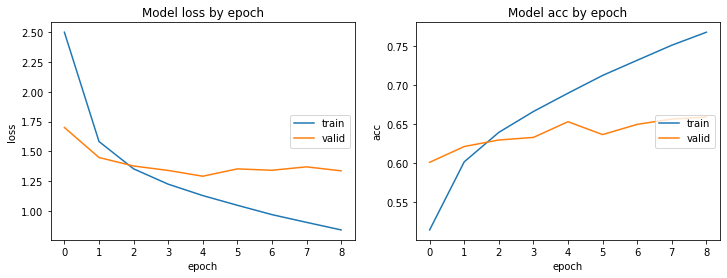

In [83]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Evaluate - test_generator***

In [84]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])
sc = valid_score[0]

266/266 [==============================] - 86s 324ms/step - loss: 1.2912 - accuracy: 0.6531
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 65.31%
[INFO] Loss:  1.291161060333252
Wall time: 1min 26s


 ***Prediction - test_generator***

In [86]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 1min 21s


In [93]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)
f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)
f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.5993253584833359
[INFO] f1 score micro average:  0.6531441356570891
[INFO] f1 score weighted average:  0.6461021383026198


***Classification_report***

In [94]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.57      0.62      0.60       643
           1       0.69      0.56      0.62       503
           2       0.54      0.69      0.60       162
           3       0.44      0.53      0.48       514
           4       0.46      0.56      0.51       664
           5       0.64      0.53      0.58       993
           6       0.74      0.87      0.80       832
           7       0.68      0.68      0.68       159
           8       0.58      0.52      0.55       970
           9       0.60      0.27      0.38       190
          10       0.72      0.83      0.77       911
          11       0.65      0.71      0.68       961
          12       0.42      0.40      0.41       319
          13       0.70      0.53      0.60       301
          14       0.70      0.70      0.70      1011
          15       0.44      0.43      0.43       533
          16       0.77      0.88      0.82      2083
          17       0.46    

***Confusion Matrix***

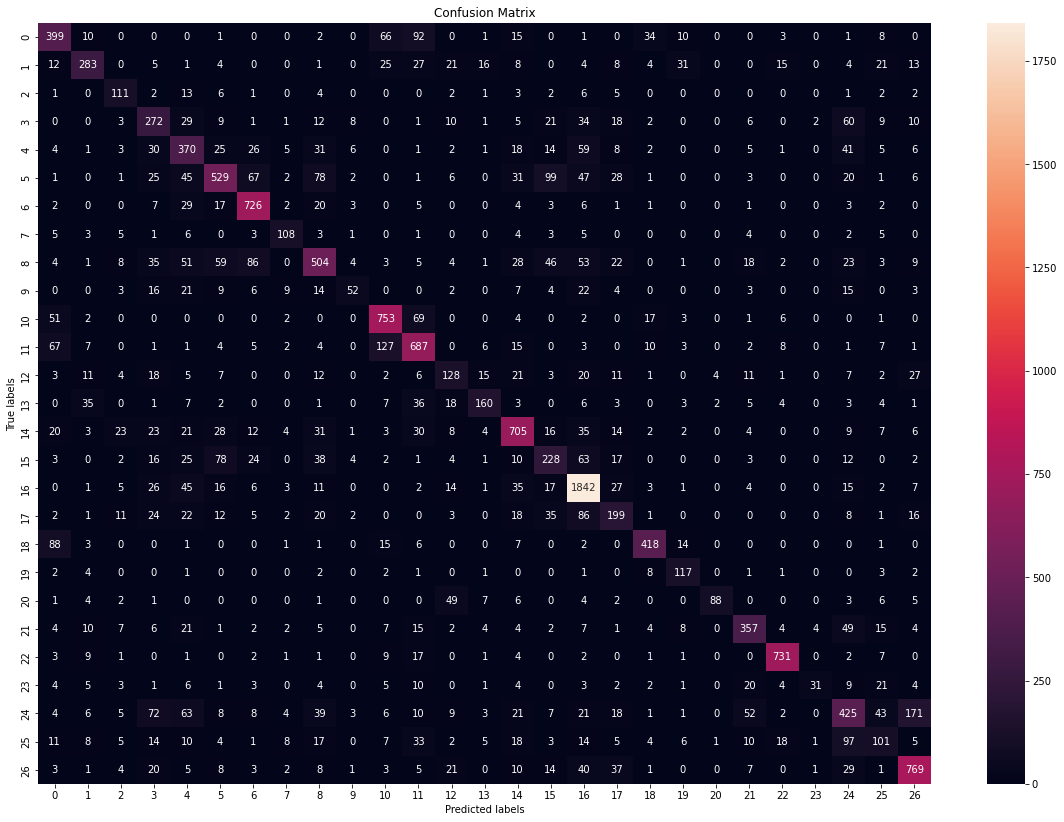

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(20,14))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

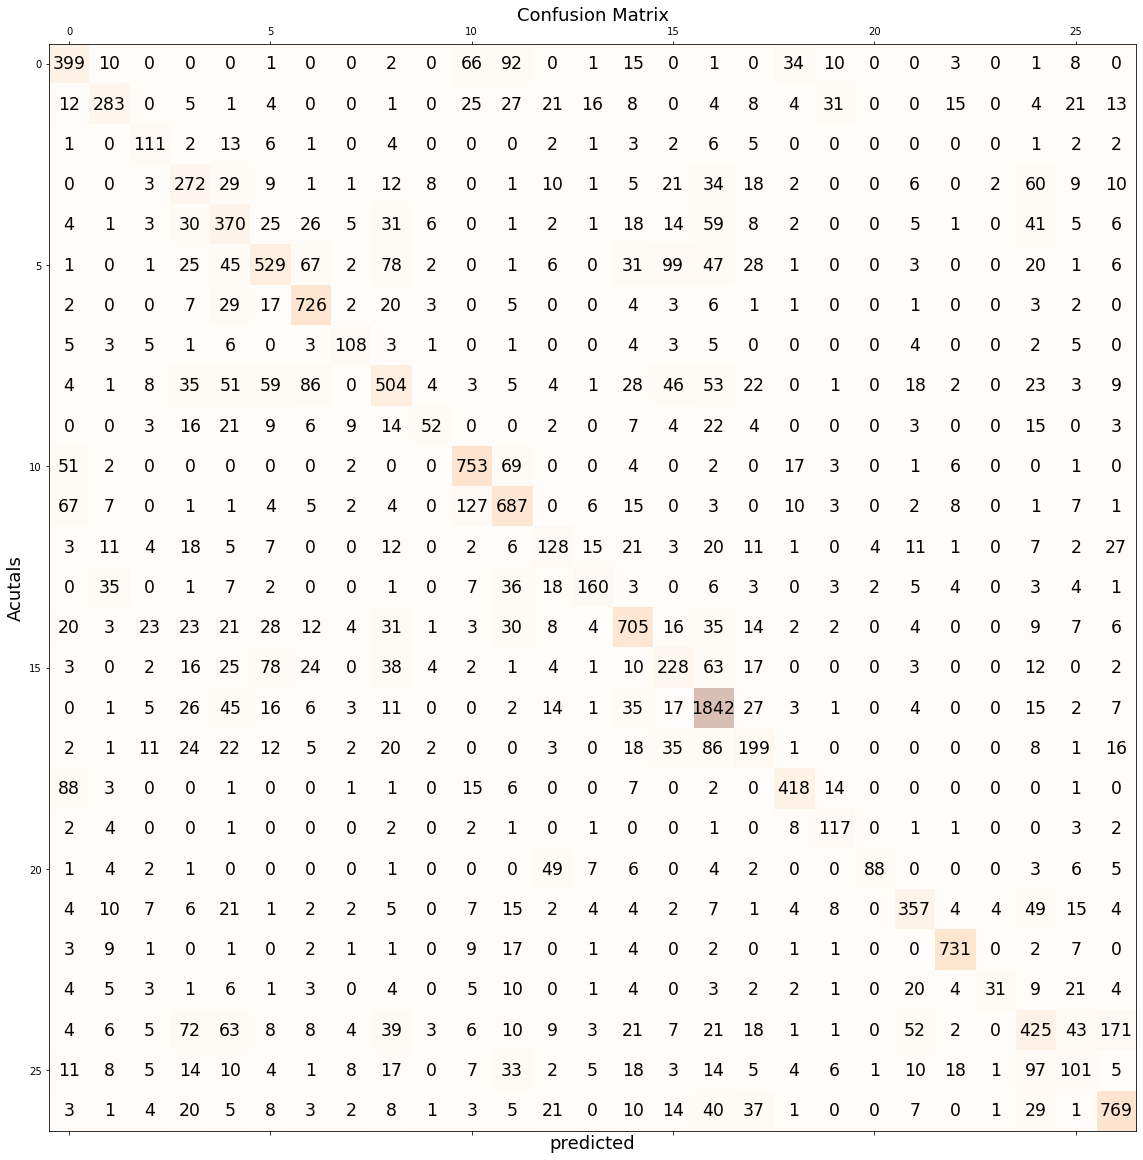

In [96]:
#Confusion matrix

matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

 ***Example of Prediction of single Image***

image file name :  image_1323313776_product_4231806212.jpg


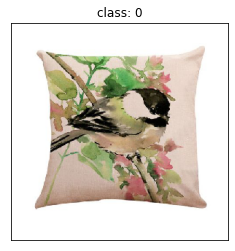

In [198]:
# Predict With Pre Trained

# Load an image
row_id = 256
#img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]
img_path =images_dir_train + df_train_im['image_name'][row_id]
print('image file name : ',df_train_im['image_name'][row_id])
img = image.load_img(img_path,target_size=(299, 299))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [199]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = im/255
im = np.expand_dims(im, axis=0)
out = model.predict(im)
im_pred= np.argmax(out)

In [200]:
def get_real_class(val):
    for real_cls, gen_label in valid_generator.class_indices.items():
         if val == gen_label:
            return int(real_cls)

    return "class doesn't exist"

In [201]:
print("------------------Predicted Class and Label ------------------------------")
print("Predicted Data Generator Label :", im_pred,', Corresponds to Real Class Number: ',get_real_class(im_pred) )
print("Predicted Label"  ,df_train_im[df_train_im['prdtypecode'] == str(im_pred)][['labels']].head(1).to_string(index=False)) 

------------------Predicted Class and Label ------------------------------
Predicted Data Generator Label : 6 , Corresponds to Real Class Number:  14
Predicted Label                                  labels
figurines, masks and role playing games


In [202]:
print("------------------Real Class and Label ------------------------------")
print("Real Class Number: ",df_train_im.loc[[row_id], :]['prdtypecode'].to_string(index=False)  )
print("Real Label: "  ,df_train_im.loc[[row_id], :]['labels'].to_string(index=False)) 

------------------Real Class and Label ------------------------------
Real Class Number:  14
Real Label:  interior accessories


 ***Save results:  Model and Training history***

In [203]:
hist_filename = 'checkpoint_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +str(nbr_Epochs)+  'Epochs.h5'

In [209]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path_output_models + hist_filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path_output_models + hist_filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path_output_models + hist_filename +'.pkl')

In [205]:
file_name = 'Model_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +str(nbr_Epochs)+  'hdf5.h5'

In [207]:
#Enregistrement du modèle
model.save(path_output_models + file_name)

***Load Previously saved Xception Model***

In [ ]:
#Rechargement du modèle :
#model = load_model("hdf5 file path")